# Linear Resolution and SLD Resolution

```Horn clauses``` are clauses (i.e., disjunctions of literals) with at most one positive literal.
A ```query``` or denial is a Horn clause without positive literal.
A ```fact``` is a Horn clause consisting of one positive literal and no negative literals.

Note that the CNF of our knights and knaves puzzle, contains one query, no facts and
 two non-Horn clauses ```B ∨ A``` and ```C ∨ A```:
```
{¬A ∨ ¬B ∨ ¬C,  B ∨ A,  C ∨ A,  ¬B ∨ A,  ¬A ∨ B}
```

Note that Prolog programs are automatically Horn clauses in CNF.
For example, the Prolog clause
```
wet :- rains, outside.
```

corresponds to the Horn clause:

```
wet ∨ ¬rains ∨ ¬outside
```

The head of a Prolog clause is a positive literal. The calls in the body correspond to negative literals.

Querys are not Prolog program clauses but stem from the Prolog console.

Let us now encode a simple Prolog program using the representation from the previous notebook:

In [1]:
:- discontiguous program/3.
:- dynamic program/3.
program(1,'weather',
   [ [pos(wet),neg(rains),neg(outside)],
     [pos(rains)],
     [pos(outside)] ]).
negate(pos(A),neg(A)).
negate(neg(A),pos(A)).

For simplicity we will assume that the positive literal is always the first literal in a clause.

Let us now perform resolution with a negative literal:

In [2]:
resolve_literal(neg(Prop),Clauses,Resolvent) :-
     member([pos(Prop)|Body],Clauses), % find a clause with a corresponding positive literal
     Resolvent=Body.

This can be used like this:

In [3]:
?- program(1,_,P),resolve_literal(neg(wet),P,Resolvent).

P = [[pos(wet),neg(rains),neg(outside)],[pos(rains)],[pos(outside)]],
Resolvent = [neg(rains),neg(outside)]

Here we find a contradiction:

In [4]:
?- program(1,_,P),resolve_literal(neg(rains),P,Resolvent).

P = [[pos(wet),neg(rains),neg(outside)],[pos(rains)],[pos(outside)]],
Resolvent = []

We can extend this code to work with a complete denial, rather than single negative literal:

In [5]:
resolve_query(Query,Clauses,Resolvent) :-
     selection_rule(Query,SelectedLiteral,RestQuery),
     resolve_literal(SelectedLiteral,Clauses,Body),
     append(Body,RestQuery,Resolvent).

selection_rule([LeftmostLiteral|Rest],LeftmostLiteral,Rest).

The above predicate uses the predicate ```select/3``` from ```library(lists)```, which can be used to select an element from a list and returns a modified list with the element removed:

In [6]:
?- program(1,_,P),resolve_query([neg(wet)],P,Resolvent).

P = [[pos(wet),neg(rains),neg(outside)],[pos(rains)],[pos(outside)]],
Resolvent = [neg(rains),neg(outside)]

As you can see, the resolvent is again a query consisting only of negative literals.
We can apply resolution again:

In [7]:
?- program(1,_,P),resolve_query([neg(rains),neg(outside)],P,Resolvent).

P = [[pos(wet),neg(rains),neg(outside)],[pos(rains)],[pos(outside)]],
Resolvent = [neg(outside)]

As you can see, the resolvent is again a query consisting only of negative literals.
We can apply resolution again:

In [8]:
?- program(1,_,P),resolve_query([neg(outside)],P,Resolvent).

P = [[pos(wet),neg(rains),neg(outside)],[pos(rains)],[pos(outside)]],
Resolvent = []

We have now reached the empty clause, i.e., a contradiction.
This means that the original proposition wet is a logical consequence of our logic program.

We can now try to encode the search for a contradiction systematically as follows:

In [9]:
prove(Proposition,Clauses) :-
    find_contradiction([neg(Proposition)],Clauses).

find_contradiction([],_). % empty clause found
find_contradiction(Query,Clauses) :-
    resolve_query(Query,Clauses,NewQuery),
    find_contradiction(NewQuery,Clauses).

Let us now check whether wet is a logical consequence of program 1:

In [10]:
?- program(1,_,Clauses), prove(wet,Clauses).

Clauses = [[pos(wet),neg(rains),neg(outside)],[pos(rains)],[pos(outside)]]

There are a few important observations:
- negative literals always come from the query
- positive literals always come from the program clauses
- the resolve_literal predicate can have multiple solutions
- the clauses in the logic program (```Clauses``` above) are never changed. 
The last point means that there is no exponential growth of the number of clauses during execution and it means we can precompile the logic program to find clauses for the given positive literals.

This procedure is called linear resolution, as the pool of clauses remains of constant size
and we "forget" earlier denials, except for backtracking when no contradiction is found.

The above code also contains a so-called selection rule/function ```selection_rule```.
This one selects the next literal chosen for resolution in the query.
- it is a function: no backtracking is needed
- there is an important property, called "independence of the selection function" which stipulates that it is correct to not backtrack
- Prolog's execution engine uses the leftmost literal by default; we have done the same above

The procedure we have implemente is called SLD-resolution:
- Selection rule driven
- Linear resolution for
- Definite clauses

(Definite clauses are clauses without using Prolog's negation operator. We will return to this later.)

Let us augment the above procedure with a few print statements:

In [11]:
trace_prove(Prop,Clauses) :- trace_find_contradiction([neg(Prop)],Clauses,1).
trace_find_contradiction([],_,Nr) :- format(' ~w: [] (contradiction)~n',[Nr]). % empty clause found
trace_find_contradiction(Query,Clauses,Nr) :-
    format(' ~w: ~w~n',[Nr,Query]), N1 is Nr+1,
    resolve_query(Query,Clauses,NewQuery),
    trace_find_contradiction(NewQuery,Clauses,N1).

In [12]:
?- program(1,_,Clauses), trace_prove(wet,Clauses).

 1: [neg(wet)]
 2: [neg(rains),neg(outside)]
 3: [neg(outside)]
 4: [] (contradiction)

Clauses = [[pos(wet),neg(rains),neg(outside)],[pos(rains)],[pos(outside)]]

The above sequence of denials is also called an ```SLD-derivation```.
An SLD-derivation which ends in a contradiction is called an ```SLD-refutation```.

Let us examine a more complicated example corresponding to the Prolog program

```
p :- q,r.
q :- t.
q :- s.
r.
s.
```

In [13]:
program(2,'Backtracking',[
      [pos(p),neg(q),neg(r)],
      [pos(q),neg(t)],
      [pos(q),neg(s)],
      [pos(r)],
      [pos(s)]
       ]) :- true.

If we now try to prove that ```p``` is a logical consequence of program 2 we will see that backtracking is required:

In [14]:
?- program(2,_,Clauses), trace_prove(p,Clauses).

 1: [neg(p)]
 2: [neg(q),neg(r)]
 3: [neg(t),neg(r)]
 3: [neg(s),neg(r)]
 4: [neg(r)]
 5: [] (contradiction)

Clauses = [[pos(p),neg(q),neg(r)],[pos(q),neg(t)],[pos(q),neg(s)],[pos(r)],[pos(s)]]

When you step through the corresponding Prolog program using the Prolog debugger you will get an output like this one (after declaring t/0 as dynamic to avoid error messages):
```
| ?-      p.
        1      1 Call: p ? 
        2      2 Call: q ? 
        3      3 Call: t ? 
        3      3 Fail: t ? 
        4      3 Call: s ? 
        4      3 Exit: s ? 
        2      2 Exit: q ? 
        5      2 Call: r ? 
        5      2 Exit: r ? 
        1      1 Exit: p ? 
yes
```

By putting the above queries into a tree we obtain a so-called ```SLD-tree``` for the program and top-level query under consideration.

Below is some code to display this SLD-tree graphically in Jupyter:

In [15]:
sld_node(Query,[shape/S,color/C],InitialQuery,ProgNr) :- sub_goal(InitialQuery,ProgNr,Query),
  (Query=[] -> S=rect,C=green ; sld_edge(Query,_,ProgNr,_) ->  S=egg, C=blue ; S=ellipse, C=red).

sub_goal(Q,_,Q).
sub_goal(Q,ProgNr,SubG) :- sld_edge(Q,_,ProgNr,NewQuery),
  sub_goal(NewQuery,ProgNr,SubG).

sld_edge(Q,Lit,ProgNr,NewQuery) :- selection_rule(Q,neg(Lit),_),
   program(ProgNr,_,Clauses), resolve_query(Q,Clauses,NewQuery).


In [16]:
?- sld_node(Q,L,[neg(p)],2).

Q = [neg(p)],
L = [shape/egg,color/blue]

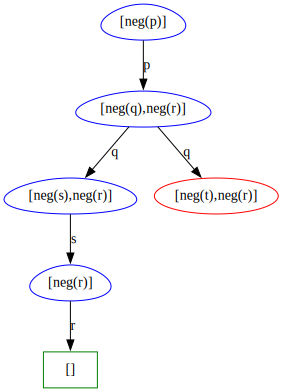

true

In [17]:
jupyter:show_graph(sld_node(_,_,[neg(p)],2),sld_edge(_,_,2,_))

In [18]:
?-sld_edge([neg(p)],L,NQ,2).

false

In [19]:
program(3,'circuit', [
    % Die Belegung von der Aufgabe:
[pos(a)], [pos(not_b)], [pos(c)],[pos(not_d)], [pos(e)],
% Schaltungen der ersten Ebene
[pos(and11) , neg(a),neg(b)],
[pos(or11) , neg(b)],
[pos(or11) , neg(c)],
[pos(and12) , neg(c),neg(d)],
[pos(not1) , neg(not_e)],
% Schaltungen der zweiten Ebene
[pos(or21) , neg(and11)],
[pos(or21) , neg(not1)],
[pos(and2) , neg(or11),neg(not1)],
[pos(or22) , neg(and12)],
[pos(or22) , neg(not1)],
[pos(not2) , neg(e)],  % \+ not1)],
% Schaltungen der dritten Ebene
[pos(and3) , neg(or21),neg(and2)],
[pos(or3) , neg(or22)],
[pos(or3) , neg(not2)],
% Schaltungen der vierten Ebene
[pos(or4) , neg(and3)],
[pos(or4) , neg(or3)],
[pos(and4) , neg(or3),neg(not2)],
% Letzte Ebene
[pos(and5) , neg(and4),neg(or4)],
[pos(output) , neg(and5)]
]) :- true.

In [20]:
?- program(3,_,Clauses), trace_prove(output,Clauses).

 1: [neg(output)]
 2: [neg(and5)]
 3: [neg(and4),neg(or4)]
 4: [neg(or3),neg(not2),neg(or4)]
 5: [neg(or22),neg(not2),neg(or4)]
 6: [neg(and12),neg(not2),neg(or4)]
 7: [neg(c),neg(d),neg(not2),neg(or4)]
 8: [neg(d),neg(not2),neg(or4)]
 6: [neg(not1),neg(not2),neg(or4)]
 7: [neg(not_e),neg(not2),neg(or4)]
 5: [neg(not2),neg(not2),neg(or4)]
 6: [neg(e),neg(not2),neg(or4)]
 7: [neg(not2),neg(or4)]
 8: [neg(e),neg(or4)]
 9: [neg(or4)]
 10: [neg(and3)]
 11: [neg(or21),neg(and2)]
 12: [neg(and11),neg(and2)]
 13: [neg(a),neg(b),neg(and2)]
 14: [neg(b),neg(and2)]
 12: [neg(not1),neg(and2)]
 13: [neg(not_e),neg(and2)]
 10: [neg(or3)]
 11: [neg(or22)]
 12: [neg(and12)]
 13: [neg(c),neg(d)]
 14: [neg(d)]
 12: [neg(not1)]
 13: [neg(not_e)]
 11: [neg(not2)]
 12: [neg(e)]
 13: [] (contradiction)

Clauses = [[pos(a)],[pos(not_b)],[pos(c)],[pos(not_d)],[pos(e)],[pos(and11),neg(a),neg(b)],[pos(or11),neg(b)],[pos(or11),neg(c)],[pos(and12),neg(c),neg(d)],[pos(not1),neg(not_e)],[pos(or21),neg(and11)],[pos(or21),neg(not1)],[pos(and2),neg(or11),neg(not1)],[pos(or22),neg(and12)],[pos(or22),neg(not1)],[pos(not2),neg(e)],[pos(and3),neg(or21),neg(and2)],[pos(or3),neg(or22)],[pos(or3),neg(not2)],[pos(or4),neg(and3)],[pos(or4),neg(or3)],[pos(and4),neg(or3),neg(not2)],[pos(and5),neg(and4),neg(or4)],[pos(output),neg(and5)]]

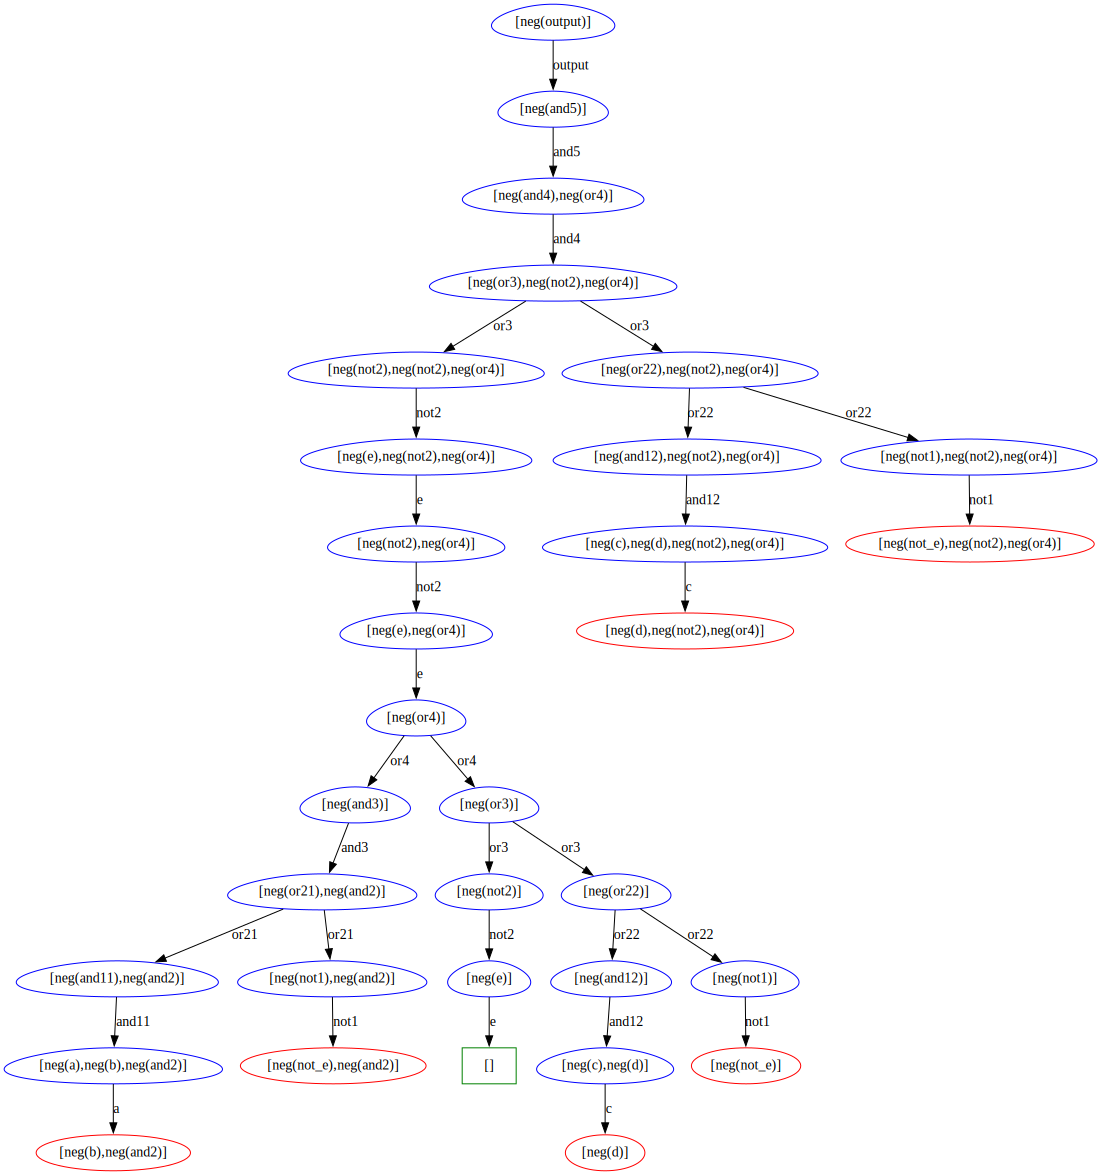

true

In [21]:
jupyter:show_graph(sld_node(_,_,[neg(output)],3),sld_edge(_,_,3,_))